### Import basic libraries

In [134]:

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats

import pandas as pd
import json
import re
import random

from PIL import Image
import base64

### Import vgg analysis libraries

In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from glob import glob
import os

import embedding_labelconcept as emb
reload(emb)
from embedding_labelconcept import *

### Load image paths 

In [3]:
# retrieve sketch paths
def list_files(path, ext='jpg'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

# extract metadata
path_to_images = '/home/bria/labelconcept/allImages'
image_paths = sorted(list_files(path_to_images))

In [4]:
## number of images
print 'Number of image paths = {}'.format(len(image_paths))

Number of image paths = 221


## Extract features

- From command line, extract features using `extract_features.py`.

## Basic helper functions for analyzing vgg features

In [402]:
## make plots directory
if not os.path.exists('./plots'):
    os.makedirs('./plots')

## loading -- this path is absolute and will need ot be changed based on computer.
## Feature matrxies are large and not extracted for all layers right now.
def load_features(layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']            
    F = np.load('/home/bria/labelconcept/python/features/FEATURES_{}.npy'.format(layers[layer_num]))
    M = pd.read_csv('/home/bria/labelconcept/python/features/METADATA.csv') 
    return F, M

# Z-score normalization to "center" the features
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

# not using right now
# def normalize_RDM(MAT):
#     X = MAT - MAT.mean(0).mean(0)
#     X = X / np.maximum(MAT.std(0).std(0), 1e-5)
#     return X


# Gets and plots RDMs for ALL classses (i.e., object categories)
def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0: ## if there examples of this class
            _mu[vi] = Xv.mean(0)
    return _mu

# Gets and plots RDMs for a select set of classses (i.e., object categories)
def get_selected_class_means(X,labels,selected_classes):
    _mu = np.zeros((len(np.unique(selected_classes)), np.shape(X)[1]))   # _mu = selected_classes x features    
    X = normalize(X) # always normalizing relative to this class as well?
    for vi, v in enumerate(np.asarray(selected_classes)): # only get means for selected classes
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

## Plotting RDM functions
def plot_rdm_all_classes(Features,M,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    ## get RDM
    labels = M.category.values
    plotLabels = np.unique(M.category.values)
    means = get_class_means(Features, labels)
    corr_mat = np.corrcoef(means)
    rdm = 1 - corr_mat
    plt.matshow(rdm, vmin=0, vmax=2) # rescale to min,max
    plt.xticks(range(len(plotLabels)), plotLabels, rotation=90);
    plt.yticks(range(len(plotLabels)), plotLabels); 
    plt.colorbar()
    ##
    plt.savefig('./plots/RDM_by_layer_{}.pdf'.format(layers[layer_num]))
    return rdm

def plot_rdm_by_selected_classes(Features,M,layer_num, selected_classes):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7'] 
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    ## get RDM
    labels = M.category.values
    labelsPlot = np.asarray(selected_classes)
    means = get_selected_class_means(Features, labels, selected_classes)
    corr_mat = np.corrcoef(means)
    rdm = 1-corr_mat
    ## plot it
    plt.matshow(rdm, vmin=0, vmax=2) # rescale to min,max
    plt.xticks(range(len(selected_classes)), selected_classes, rotation=90);
    plt.yticks(range(len(selected_classes)), selected_classes); 
    plt.colorbar()
    ##
    plt.savefig('./plots/RDM_by_layer_{}_set_{}.pdf'.format(layers[layer_num],selected_classes))
    return rdm

### Functions for split-half reliability
# if you want to get a random half for a category - compute reliability
def get_random_half_selected_class_means(X,labels,selected_classes):
    _mu = np.zeros((len(np.unique(selected_classes)), np.shape(X)[1]))   # _mu = selected_classes x features 
    _mu2 = np.zeros((len(np.unique(selected_classes)), np.shape(X)[1]))   # _mu = selected_classes x features 
    X = normalize(X) # always normalizing relative to this class as well?
    for vi, v in enumerate(np.asarray(selected_classes)): # only get means for selected classes
        Xv = X[labels == v]
        nv = Xv.shape[0]
        half = int(np.floor(nv/2)) # size of half
        rand_samples = np.random.randint(0,nv,half) # get random set of images
        rand_samples_2 = np.asarray([x for x in np.arange(0,nv) if x not in rand_samples]) # take other images not sampled
        random_half = Xv[rand_samples,:] # compute means for random halves and store
        random_half_2 = Xv[rand_samples_2,:]
        _mu[vi] = random_half.mean(0)
        _mu2[vi]= random_half_2.mean(0)
    return _mu,_mu2

## correlate spearman's-r reliabilty between random halves
def get_RDMs_splithalf(F,M,selected_classes):
    labels = M.category.values
    means_half1, means_half2 = get_random_half_selected_class_means(F, labels, selected_classes)
    H1RDM = np.corrcoef(means_half1)
    H2RDM = np.corrcoef(means_half2)
    dim = H1RDM.shape[0]
    cor = stats.spearmanr(np.ravel(H1RDM[np.triu_indices(dim,k=1)]),np.ravel(H2RDM[np.triu_indices(dim,k=1)]))[0]
    return cor

### Choose layer to analyze and load features

In [420]:
## Layer choice - toggle HERE
layer_ind = 2
layer_ind = 6

In [421]:
##
layers = ['P1','P2','P3','P4','P5','FC6','FC7']   
print "Getting features for layer {} ... ".format(layers[layer_ind])

## Load in image features for a given layer
F, M = load_features(layer_ind)
M = M.reset_index(drop=True)
print "We have {} features for {} images in layer {}".format(np.shape(F)[1],np.shape(F)[0],layers[layer_ind])


Getting features for layer FC7 ... 
We have 4096 features for 221 images in layer FC7


### Show all categories in this layer

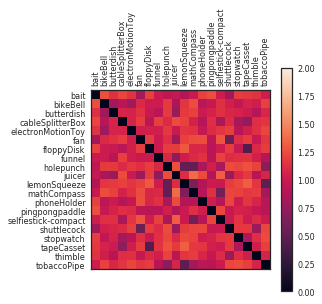

In [394]:
## Plot RDM for this layer and save it
RDM = plot_rdm_all_classes(F,M,layer_ind)

In [395]:
# Hand chosen categories based on FC7 dissimilarities
set1 = ['shuttlecock','fan','thimble','electronMotionToy']
set2 = ['tobaccoPipe','lemonSqueeze','phoneHolder','cableSplitterBox']
set3 = ['floppyDisk','tapeCasset','pingpongpaddle','bait']
set4 = ['selfiestick-compact','mathCompass','holepunch','bikeBell']
set5 = ['funnel','juicer','butterdish','stopwatch']

In [ ]:
## Compute RDM reliabilty of each set for this layer
num_iters = 100
num_sets = 5
cor_avg = np.zeros((num_iters,num_sets))
sets = ['set1','set2','set3','set4','set5']
for set_index, this_set in enumerate(np.asarray(sets)):
    this_set_var = vars()[this_set] # convert to variable
    for iter in np.arange(0,num_iters):
        cor =  get_RDMs_splithalf(F,M,this_set_var) # calls function above
        cor_avg[iter,set_index] = cor # store this correaltion

### Output split-half RDM reliability for each set in this layer

In [361]:
reliability = cor_avg.mean(0)
for this_set in np.arange(0,5):
    print "set {} has reliability of r={} in layer {}".format(this_set+1,np.round_(reliability[this_set],2), layer_ind)

set 1 has reliability of r=0.92
set 2 has reliability of r=0.81
set 3 has reliability of r=0.95
set 4 has reliability of r=0.87
set 5 has reliability of r=0.78


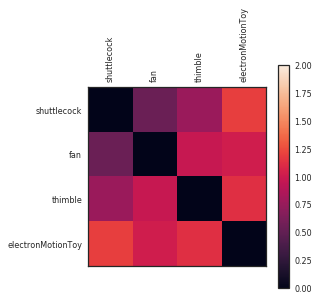

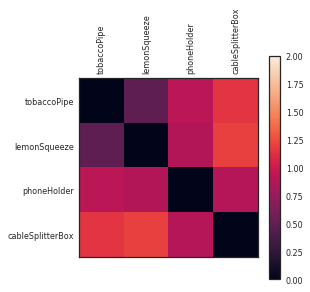

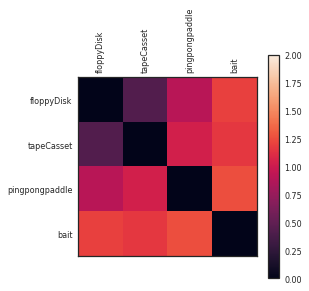

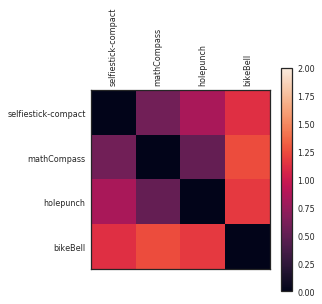

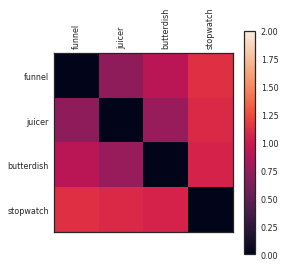

In [424]:
RDM_set1 = plot_rdm_by_selected_classes(F, M, layer_num, set1)
RDM_set2 = plot_rdm_by_selected_classes(F, M, layer_num, set2)
RDM_set3 = plot_rdm_by_selected_classes(F, M, layer_num, set3)
RDM_set4 = plot_rdm_by_selected_classes(F, M, layer_num, set4)
RDM_set5 = plot_rdm_by_selected_classes(F, M, layer_num, set5)


### Get dissimilarity values from RDM for target categories

In [425]:
def get_dissim_values(RDM,selected_set,ref_category_name):
    selected_set = np.asarray(selected_set)
    arr_index = np.where(selected_set == ref_category_name)
    ref_category = arr_index[0]
    assert ref_category == 0 ## should always be the first one
    ##
    dissimValues = RDM[ref_category,:]
    ## check ref category index + 1 dissimilarity is always 0
    check = RDM[ref_category+1,ref_category+1]
    assert check < 1e-7 # minmally small values because sometimes small corr?
    ## get dissim values for this set
    dissimValues = RDM[ref_category,:]
    dissimValues = np.delete(dissimValues,0)
    return dissimValues

## initialize
num_test_trials = 3
all_dissim_values = np.zeros((num_sets,num_test_trials)) 

## fill in
all_dissim_values[0,:] = get_dissim_values(RDM_set1,set1,set1[0])
all_dissim_values[1,:] = get_dissim_values(RDM_set2,set2,set2[0])
all_dissim_values[2,:] = get_dissim_values(RDM_set3,set3,set3[0])
all_dissim_values[3,:] = get_dissim_values(RDM_set4,set4,set4[0])
all_dissim_values[4,:] = get_dissim_values(RDM_set5,set5,set5[0])

### Plot dissimilarity values for all five sets for this layer

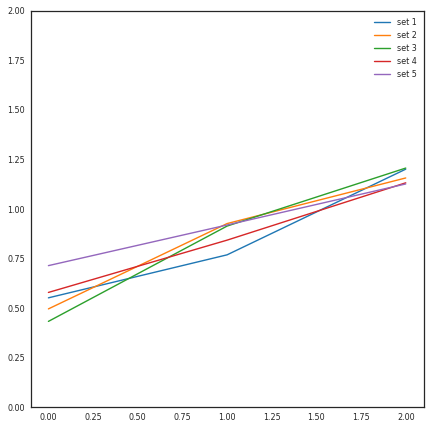

In [426]:
def plot_dissim_values(all_dissim_values,layer_ind):
    plt.figure(figsize=(6,6))
    for set_ind in np.arange(0,5):
        these_dissim_values=all_dissim_values[set_ind,:]
        plt.plot(np.arange(0,3),these_dissim_values, label='set ' + str(set_ind+1))
        plt.tight_layout()
    axes = plt.gca()
    axes.set_ylim([0,2])
    plt.legend()
    plt.savefig('./plots/dissimValues_layer_{}.pdf'.format(layer_ind))
            
plot_dissim_values(all_dissim_values,layer_ind)


In [107]:
# ## get some dissimilarity values relative to a given reference category index
# dissimValues = RDM[ref_category,:]
# dissimValues = np.delete(dissimValues,ref_category) # delete the identity values
# labelsPlot = np.delete(labelsPlot,ref_category) # delete the identity category (ref category)

# ## sort by dissimilarity
# ind =  np.argsort(dissimValues)
# dissimValues = dissimValues[ind]
# labelsPlot = labelsPlot [ind]

([<matplotlib.axis.XTick at 0x7f459b26bd90>,
 <a list of 3 Text xticklabel objects>)

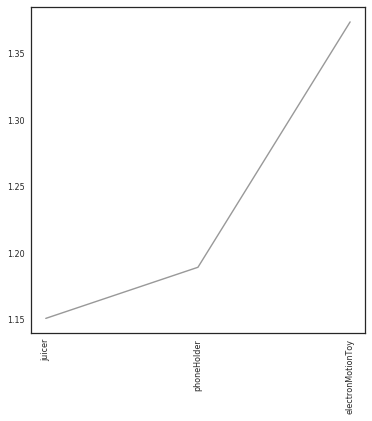

array([ 1.27471035,  1.3947001 ,  0.        ,  1.11276242])

In [109]:
### Correlations between features in FC7 each class (e.g., object category)

In [76]:
# make general function
# def corr_cohort_classes(cohort1,cohort2,uniqueLabels):
#     if  np.shape(cohort1)==np.shape(cohort2): ## make sure same shape
#         classCor=np.zeros(np.shape(uniqueLabels)[0]) # open variable
#         for vi, v in enumerate(np.asarray(uniqueLabels)):
#             cohort1Vec = cohort1[uniqueLabels == v,:]
#             cohort2Vec = cohort2[uniqueLabels == v,:]
#             cohort1Vec=np.reshape(cohort1Vec,np.shape(cohort1Vec)[1],np.shape(cohort1Vec)[0]) # resahpe for corr
#             cohort2Vec=np.reshape(cohort2Vec,np.shape(cohort2Vec)[1],np.shape(cohort2Vec)[0])# resahpe for corr
#             classCor[vi]=stats.pearsonr(cohort1Vec,cohort2Vec)[0]
#         return classCor
    
# uniqueLabels=np.unique(KM.label.values)
# means_adult = get_class_means(AF, AM.label.values)
# means_kid = get_class_means(KF, KM.label.values)
# classCor=corr_cohort_classes(means_adult,means_kid,np.unique(KM.label.values))
# sortInd=np.argsort(classCor)
# print uniqueLabels[sortInd]
# print classCor[sortInd]

## print fc7 cross-cohort correlations

# dim = KRDM.shape[0]
# cor = stats.spearmanr(np.ravel(KRDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
# print 'Correlation between adult and overall kid RDM: {}'.format(cor)

##### generate and save out RDMs as separate npy files

In [ ]:
# ## subsampling on or off?
# subsample_on = 1

# ## load in adult features
# really_run = 1
# if really_run:
#     for layer_num in np.arange(7):
#         print 'Loading in adult features for layer {}...'.format(layer_num)
#         AF, AM = load_features('adult',layer_num)
#         AF, AM = remove_practice_trials(AF, AM)
#         AM = AM.reset_index(drop=True)
#         AF, AM = adult_preproc(AF, AM, these_labels)
#         ## subsample features especially for lower layers
#         if subsample_on:
#             num_features = AF.shape[1]
#             size_subsample = 100000
#             if num_features>size_subsample:
#                 feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
#                 AF = AF[:,feat_inds]         
        
#         print 'Shape of adult feature tensor: {}'.format(np.shape(AF))

#         ## get RDM
#         cohort = 'adult'
#         print 'Getting and saving RDM...'
#         RDM = get_RDM(AM, AF,sort_inds)
#         ## save out RDM as npy
#         np.save('./rdm/RDM_{}_{}.npy'.format(cohort,layer_num),ARDM)
        
#     print 'All done!'

Loading in adult features for layer 0...


In [ ]:
# ## subsampling on or off?
# subsample_on = 1

# really_run = 1
# lb = 0
# ub = 7
# if really_run:
#     ## loop through all kid layers and save out their RDM
#     for layer_num in np.arange(lb,ub):
#         ## load in kid features
#         KF, KM = load_features('kid',layer_num)
#         KF, KM = remove_practice_trials(KF, KM)
#         KM = KM.reset_index(drop=True)
#         KF, KM = preproc_kid(KF, KM, these_labels)
#         print 'Shape of kid feature tensor: {}'.format(np.shape(KF))
#         ## subsample features especially for lower layers
#         if subsample_on:        
#             num_features = KF.shape[1]
#             size_subsample = 100000
#             if num_features>size_subsample:
#                 feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
#                 KF = KF[:,feat_inds]           
        
#         ## get RDM
#         print 'Getting and saving RDM...'
#         cohort = 'kid'
#         KRDM = get_RDM(KM, KF,sort_inds)
#         ## save out RDM as npy
#         np.save('./rdm/RDM_{}_{}.npy'.format(cohort,layer_num),KRDM)
        
#         print 'Saved OVERALL KID RDMs for layer {}!'.format(layer_num)        
                
#     ## loop through all kid layers and save out their RDM
#     for layer_num in np.arange(lb,ub):
#         ## load in kid features
#         KF, KM = load_features('kid',layer_num)
#         KF, KM = remove_practice_trials(KF, KM)
#         KM = KM.reset_index(drop=True)
#         KF, KM = preproc_kid(KF, KM, these_labels)
#         ## subsample features especially for lower layers
#         if subsample_on:
#             num_features = KF.shape[1]
#             size_subsample = 100000
#             if num_features>size_subsample:
#                 feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
#                 KF = KF[:,feat_inds]              
        
#         ## get RDM for older kids (7,8,9,10)
#         ind = KM.index[KM['coarse_age'] == 'older']
#         meta = KM.loc[ind]
#         feat = KF[ind.tolist()]
#         print 'Shape of older kid feature tensor: {}'.format(np.shape(feat))        
#         ORDM = get_RDM(meta, feat,sort_inds)
#         np.save('./rdm/RDM_{}_{}.npy'.format('older',layer_num),ORDM)            
#         print 'Saved OLDER KID RDMs for layer {}!'.format(layer_num)        
            
#     for layer_num in np.arange(lb,ub):
#         ## load in kid features
#         KF, KM = load_features('kid',layer_num)
#         KF, KM = remove_practice_trials(KF, KM)
#         KM = KM.reset_index(drop=True)
#         KF, KM = preproc_kid(KF, KM, these_labels)
#         ## subsample features especially for lower layers
#         if subsample_on:
#             num_features = KF.shape[1]
#             size_subsample = 50000
#             if num_features>size_subsample:
#                 feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
#                 KF = KF[:,feat_inds]         
                        
#         ## get RDM for younger kids (3,4,5,6)            
#         ind = KM.index[KM['coarse_age'] == 'younger']
#         meta = KM.loc[ind]
#         feat = KF[ind.tolist()]
#         print 'Shape of younger kid feature tensor: {}'.format(np.shape(feat))                
#         YRDM = get_RDM(meta, feat,sort_inds)
#         np.save('./rdm/RDM_{}_{}.npy'.format('younger',layer_num),YRDM)             
#         print 'Saved YOUNGER KID RDMs for layer {}!'.format(layer_num)
                

##### plot layer-wise cross-cohort similarity

In [ ]:
# corOA = []
# corYA = []

# for layer_num in np.arange(7):
#     Y = np.load('./rdm/RDM_younger_{}.npy'.format(layer_num))
#     O = np.load('./rdm/RDM_older_{}.npy'.format(layer_num))
#     A = np.load('./rdm/RDM_adult_{}.npy'.format(layer_num))

#     dim = O.shape[0]
#     rOA = stats.spearmanr(np.ravel(O[np.triu_indices(dim,k=1)]),np.ravel(A[np.triu_indices(dim,k=1)]))[0]
#     rYA = stats.spearmanr(np.ravel(Y[np.triu_indices(dim,k=1)]),np.ravel(A[np.triu_indices(dim,k=1)]))[0]

#     corOA.append(rOA)
#     corYA.append(rYA)

# import seaborn as sns
# sns.set_context('talk')
# sns.set_style('white')
# plt.figure(figsize=(6,6))
# plt.plot(np.arange(1,8),corYA,label='younger vs. adult',color=(0.6,0.6,0.6))
# plt.plot(np.arange(1,8),corOA,label='older vs. adult',color=(0.2,0.2,0.2))
# plt.xlabel('model layer')
# plt.ylabel('between-cohort similarity')
# plt.legend()
# # plt.savefig('./plots/btw_cohort_similarity.pdf')